In [53]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import scipy
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

%matplotlib inline

### Problem Statement

Our client is a national quick service restaurant which delivers food to its customers. There are many known drivers of sales for this restaurant. While these drivers of sales are known, their impact upon each other is not. We also don't know what their impact on online sales are. These drivers have also not been independently confirmed as significant metrics for success of campaigns. For this project I will be looking exclusively at data from the Atlanta market. Processes from this study will then be applied to other markets in order to do localized predictions. We will use decision trees with an ensemble approach and cross validation in order to see whether we can predict online sales using these metrics.


In [54]:
#importing nfl 2014 schedule and results data set, downloaded from sportsreference.com
nfl14 = pd.read_csv('../Assets/nfl2014schedule.csv') 
nfl14['Date'] = '2014 ' + nfl14['Date']

In [55]:
#importing nfl 2015 schedule and results data set, downloaded from sportsreference.com

nfl15 = pd.read_csv('../Assets/nfl2015schedule.csv') 
nfl15['Date'] = '2015 ' + nfl15['Date']

In [56]:
#joining the dataframes
nflSched = pd.concat([nfl14,nfl15])

In [57]:
nflSched.head()

,Week,Day,Date,Winner/tie,Unnamed: 4,Loser/tie,Unnamed: 6,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,2014 September 4,Seattle Seahawks,NaN,Green Bay Packers,boxscore,36,16,398,1,255,1
1,1,Sun,2014 September 7,Atlanta Falcons,NaN,New Orleans Saints,boxscore,37,34,568,1,472,2
2,1,Sun,2014 September 7,Houston Texans,NaN,Washington Redskins,boxscore,17,6,321,1,372,2
3,1,Sun,2014 September 7,Carolina Panthers,@,Tampa Bay Buccaneers,boxscore,20,14,334,0,264,3
4,1,Sun,2014 September 7,Buffalo Bills,@,Chicago Bears,boxscore,23,20,360,1,427,3


In [58]:
#Dropping columns that won't help predict sales
nflSched.drop(['Week','Day','Unnamed: 4','Unnamed: 6','PtsW','PtsL','YdsW','TOW','YdsL','TOL'], axis=1, inplace=True)

In [59]:
nflSched.head()

,Date,Winner/tie,Loser/tie
0,2014 September 4,Seattle Seahawks,Green Bay Packers
1,2014 September 7,Atlanta Falcons,New Orleans Saints
2,2014 September 7,Houston Texans,Washington Redskins
3,2014 September 7,Carolina Panthers,Tampa Bay Buccaneers
4,2014 September 7,Buffalo Bills,Chicago Bears


In [60]:
#eliminating strings that were found in empty rows in the dataframe
nflSched = nflSched[nflSched['Date']!= '2014 Date']
nflSched = nflSched[nflSched['Date']!= '2014 Playoffs']
nflSched = nflSched[nflSched['Date']!= '2015 Date']
nflSched = nflSched[nflSched['Date']!= '2015 Playoffs']

In [61]:
#converting to datetime and setting as index
nflSched['Date'] = pd.to_datetime(nflSched['Date'], format='%Y %B %d')
nflSched.set_index('Date', inplace=True)

In [62]:
#adding a column so that we will have a column that indicates dates that have an NFL game
nflSched['NflGame'] = 1

In [63]:
nflSched.tail()

,Winner/tie,Loser/tie,NflGame
Date,,,
2015-01-17,Denver Broncos,Pittsburgh Steelers,1
2015-01-17,Carolina Panthers,Seattle Seahawks,1
2015-01-24,Carolina Panthers,Arizona Cardinals,1
2015-01-24,Denver Broncos,New England Patriots,1
2015-02-07,Denver Broncos,Carolina Panthers,1


In [64]:
#importing college football 2014 and 2015 schedule and results data set, downloaded from sportsreference.com

cfb14 = pd.read_csv('../Assets/cfb2014schedule.csv') 
cfb15 = pd.read_csv('../Assets/cfb2015schedule.csv') 
    

In [65]:
#combining the dataframes
cfbSched = pd.concat([cfb14,cfb15])

In [66]:
#dropping columns that I don't think will be good predictors
cfbSched.drop(['Rk','Wk','Time','Day','Pts','Unnamed: 7','Pts.1','Notes'], axis=1, inplace=True)

In [67]:
#removing columns that just contain the string 'Date'
cfbSched = cfbSched[cfbSched['Date']!= 'Date']

In [68]:
#converting to datetime and setting as index
cfbSched['Date'] = pd.to_datetime(cfbSched['Date'], format='%b %d %Y')
cfbSched.set_index('Date', inplace=True)

In [69]:
#adding a column so that we will have a column that indicates dates that have an cfb game
cfbSched['cfbGame'] = 1

In [70]:
cfbSched=cfbSched.rename(columns = {'Winner/Tie':'CfbWinner', 'Loser/Tie':'CfbLoser', 'TV':'CfbTV'})

In [71]:
cfbSched.head()

,CfbWinner,CfbLoser,CfbTV,cfbGame
Date,,,,
2014-08-28,(19) Arizona State,Weber State,Pac-12 Network,1
2014-08-28,(18) Mississippi,Boise State,ESPN,1
2014-08-28,(21) Texas A&amp;M,(9) South Carolina,SEC Network,1
2014-08-29,(8) Michigan State,Jacksonville State,Big Ten Network,1
2014-08-30,(2) Alabama,West Virginia,ESPN 2,1


In [72]:
#importing weather data from the noaa
Weather = pd.read_csv('../Assets/AtlWeather.csv') 

In [73]:
#converting to datetime
Weather['DATE'] = pd.to_datetime(Weather['DATE'], format='%Y%m%d')


In [74]:
Weather.head()

,STATION,STATION_NAME,DATE,MDPR,DAPR,PRCP,SNWD,SNOW,PSUN,TSUN,...,TMIN,TOBS,WESD,WESF,WT01,WT06,WT02,WT04,WT08,WT03
0,GHCND:US1GADK0022,DUNWOODY 1.8 WNW GA US,2014-01-02,-9999.0,-9999,0.05,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999
1,GHCND:US1GADK0022,DUNWOODY 1.8 WNW GA US,2014-01-03,-9999.0,-9999,0.16,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999
2,GHCND:US1GADK0022,DUNWOODY 1.8 WNW GA US,2014-01-05,-9999.0,-9999,0.00,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999
3,GHCND:US1GADK0022,DUNWOODY 1.8 WNW GA US,2014-01-06,-9999.0,-9999,0.11,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999
4,GHCND:US1GADK0022,DUNWOODY 1.8 WNW GA US,2014-01-10,-9999.0,-9999,0.18,-9999.0,-9999.0,-9999,-9999,...,-9999,-9999,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999


In [75]:
Weather.columns

Index([u'STATION', u'STATION_NAME', u'DATE', u'MDPR', u'DAPR', u'PRCP',
       u'SNWD', u'SNOW', u'PSUN', u'TSUN', u'TAVG', u'TMAX', u'TMIN', u'TOBS',
       u'WESD', u'WESF', u'WT01', u'WT06', u'WT02', u'WT04', u'WT08', u'WT03'],
      dtype='object')

In [76]:
#dropping columns we don't need, and eliminating null value place holders
Weather.drop([u'STATION',u'STATION_NAME',u'MDPR',u'DAPR',u'SNWD',u'TOBS',u'WESD'
             , u'WESF', u'WT01', u'WT06', u'WT02', u'WT04', u'WT08', u'WT03','PSUN','TAVG','SNOW','TSUN'], axis=1, inplace=True)

Weather.replace('-9999',np.nan, inplace=True)
Weather.replace('-9999.0',np.nan, inplace=True)

In [77]:
Weather.rename(columns = {'DATE':'Date'}, inplace=True)
Weather.set_index('Date', inplace=True)

In [78]:
#There are many weather stations across the Atlanta area, so we are taking the mean of these stations to estimate weather for
#the metro area
Weather = Weather.groupby(Weather.index).mean()

In [79]:
Weather.head()

,PRCP,TMAX,TMIN
Date,,,
2014-01-01,0.001538,46.25,32.00
2014-01-02,0.087692,50.50,27.00
2014-01-03,0.122963,38.75,20.50
2014-01-04,0.000000,35.75,22.00
2014-01-05,0.015600,46.25,31.25


In [80]:
Final = pd.merge(Weather, cfbSched, left_index=True, right_index=True, how='outer')
Final = pd.merge(Final, nflSched, left_index=True, right_index=True, how='outer')
Final.head()

,PRCP,TMAX,TMIN,CfbWinner,CfbLoser,CfbTV,cfbGame,Winner/tie,Loser/tie,NflGame
Date,,,,,,,,,,
2014-01-01,0.001538,46.25,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,0.087692,50.50,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.122963,38.75,20.5,NaN,NaN,NaN,NaN,Baltimore Ravens,Pittsburgh Steelers,1.0
2014-01-03,0.122963,38.75,20.5,NaN,NaN,NaN,NaN,Carolina Panthers,Arizona Cardinals,1.0
2014-01-04,0.000000,35.75,22.0,NaN,NaN,NaN,NaN,Dallas Cowboys,Detroit Lions,1.0


In [81]:
#slicing the dataframe to include the pro and college football seasons from 2014 to 2015
Final = Final.ix['2014-8':'2016-03']

In [82]:
Final.head()

,PRCP,TMAX,TMIN,CfbWinner,CfbLoser,CfbTV,cfbGame,Winner/tie,Loser/tie,NflGame
Date,,,,,,,,,,
2014-08-01,0.590833,81.666667,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-02,0.010952,84.333333,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-03,0.000476,88.333333,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-04,0.000000,89.666667,68.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-05,0.000000,89.333333,67.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#importing client data for Atlanta area 
conv = pd.read_csv('../Assets/ProgConv.csv') 

In [84]:
conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12946 entries, 0 to 12945
Data columns (total 16 columns):
Delivery Date                             12946 non-null object
Platform Name                             12946 non-null object
IO Tactic                                 12946 non-null object
Market                                    12946 non-null object
Period                                    12946 non-null object
Year                                      12946 non-null float64
Creative Tag                              2995 non-null object
Creative Size                             12946 non-null object
Impressions                               12946 non-null float64
Clicks                                    12946 non-null float64
Billable Spend                            12946 non-null float64
eCPM                                      12946 non-null float64
CTR                                       12946 non-null float64
Client Weighted Hard Total Conversions    12376 non-nu

In [85]:
#selecting the columns that we may use as targets for our predictors
conv = conv[['Delivery Date', 'Clicks','Billable Spend','CTR','Client Weighted Hard Total Conversions'
                 ,'Client Total Revenue','ROAS']]

In [86]:
conv.set_index('Delivery Date', inplace=True)

In [87]:
#there are many locations for the client, so we need to group by date to consolidate the data for all of Atlanta
conv = conv.groupby(conv.index).mean()

In [88]:
#merging the dataframe with the final dataframe
Final = pd.merge(Final, conv, left_index=True, right_index=True, how='outer')


In [89]:
#slicing the dataframe to include the pro and college football seasons from 2014 to 2015
Final = Final.ix['2014-8':'2016-3']

In [90]:
Final.rename(columns = {'Client Weighted Hard Total Conversions':'Conversions','Client Total Revenue':'Revenue'}, inplace=True)

In [91]:
Final['cfbGame'].replace('NaN', 0.0,inplace=True)
Final['NflGame'].replace('NaN', 0.0, inplace=True)
#1=game on that day, 0=no game

In [92]:
Final.columns

Index([u'PRCP', u'TMAX', u'TMIN', u'CfbWinner', u'CfbLoser', u'CfbTV',
       u'cfbGame', u'Winner/tie', u'Loser/tie', u'NflGame', u'Clicks',
       u'Billable Spend', u'CTR', u'Conversions', u'Revenue', u'ROAS'],
      dtype='object')

In [93]:
#adding day of week as a predictor
Final['Day']=Final.index.weekday
columnsTitles = [u'Day',u'PRCP', u'TMAX', u'TMIN', u'CfbWinner', u'CfbLoser', u'CfbTV',
       u'cfbGame', u'Winner/tie', u'Loser/tie', u'NflGame', u'Clicks',
       u'Billable Spend', u'CTR', u'Conversions', u'Revenue', u'ROAS']
Final.reindex(columns=columnsTitles)

,Day,PRCP,TMAX,TMIN,CfbWinner,CfbLoser,CfbTV,cfbGame,Winner/tie,Loser/tie,NflGame,Clicks,Billable Spend,CTR,Conversions,Revenue,ROAS
2014-08-01,4,0.590833,81.666667,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.285714,9.704286,0.000000,5.714286,129.215714,6.621429
2014-08-02,5,0.010952,84.333333,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3.250000,18.437500,0.000000,9.375000,176.066250,3.306250
2014-08-03,6,0.000476,88.333333,66.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3.875000,18.456250,0.031250,7.750000,162.391250,6.171250
2014-08-04,0,0.000000,89.666667,68.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,4.000000,18.477500,0.000000,5.750000,97.411250,1.352500
2014-08-05,1,0.000000,89.333333,67.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,4.000000,18.477500,0.011250,8.000000,145.146250,6.740000
2014-08-06,2,0.000000,91.666667,65.000000,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3.500000,18.461250,0.000000,6.625000,115.633750,3.516250
2014-08-07,3,0.020370,94.666667,69.333333,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2.375000,18.270000,0.000000,7.250000,128.951250,1.836250
2014-08-08,4,0.868966,89.000000,69.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3.625000,20.360000,0.000000,13.625000,270.692500,6.640000
2014-08-09,5,1.504483,89.333333,69.666667,NaN,NaN,NaN,0.0,NaN,NaN,0.0,5.000000,20.325000,0.001250,13.500000,310.377500,8.080000
2014-08-10,6,0.711538,85.333333,72.000000,NaN,NaN,NaN,0.0,NaN,NaN,0.0,3.700000,15.261000,0.003000,7.500000,141.782000,4.400000


In [94]:
#!brew services start postgresql
#!createdb Rforest

#establishing connection to SQL database, dumping final table into database
#user = "postgres:Lumberjack1"
user = "jb:Lumberjack1"
engine = sqlalchemy.create_engine('postgresql://{}{}'.format(user,'@localhost:5432/Rforest'))
Final.to_sql("final", con = engine, if_exists="replace")


In [95]:
#EDA
Final.corr()

,PRCP,TMAX,TMIN,cfbGame,NflGame,Clicks,Billable Spend,CTR,Conversions,Revenue,ROAS,Day
PRCP,1.000000,-0.077203,0.150462,0.029703,-0.003670,-0.122358,-0.072230,-0.064136,-0.044568,-0.046385,-0.075288,-0.026129
TMAX,-0.077203,1.000000,0.860156,0.005260,-0.175960,0.091018,0.005282,0.172964,-0.321191,-0.336925,-0.021012,-0.104951
TMIN,0.150462,0.860156,1.000000,0.008162,-0.138572,-0.000186,-0.020395,0.179927,-0.393665,-0.394801,-0.017439,-0.087892
cfbGame,0.029703,0.005260,0.008162,1.000000,-0.494896,0.097253,0.061691,0.020754,0.230494,0.302402,0.055610,0.123858
NflGame,-0.003670,-0.175960,-0.138572,-0.494896,1.000000,0.042183,0.079479,-0.085799,0.027899,-0.011695,0.037289,0.370927
Clicks,-0.122358,0.091018,-0.000186,0.097253,0.042183,1.000000,0.664905,0.076108,0.487437,0.446682,-0.017016,0.066865
Billable Spend,-0.072230,0.005282,-0.020395,0.061691,0.079479,0.664905,1.000000,-0.101818,0.452264,0.552587,0.071264,0.113858
CTR,-0.064136,0.172964,0.179927,0.020754,-0.085799,0.076108,-0.101818,1.000000,-0.149492,-0.174037,-0.019048,-0.061635
Conversions,-0.044568,-0.321191,-0.393665,0.230494,0.027899,0.487437,0.452264,-0.149492,1.000000,0.957661,0.019645,0.217432
Revenue,-0.046385,-0.336925,-0.394801,0.302402,-0.011695,0.446682,0.552587,-0.174037,0.957661,1.000000,0.078942,0.260996


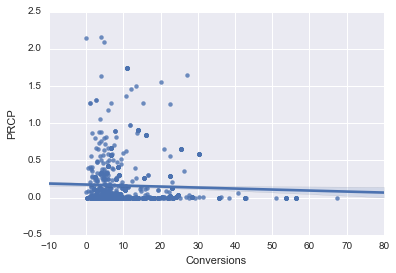

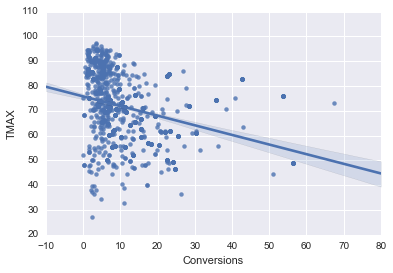

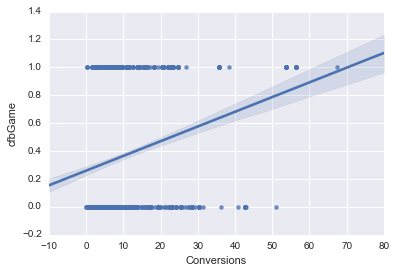

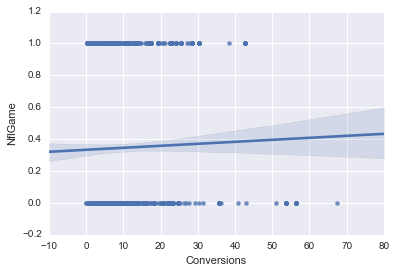

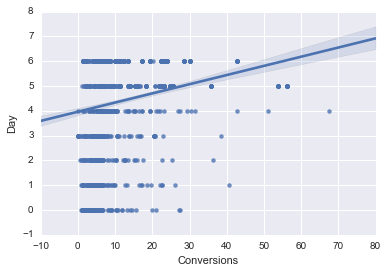

In [96]:
#EDA
plt.figure(1)
plt.subplot(1, 1, 1)
sns.regplot(Final['Conversions'],Final['PRCP'])

plt.figure(2)
plt.subplot(1, 1, 1)
sns.regplot(Final['Conversions'],Final['TMAX'])

plt.figure(3)
plt.subplot(1, 1, 1)
sns.regplot(Final['Conversions'],Final['cfbGame'])

plt.figure(4)
plt.subplot(1, 1, 1)
sns.regplot(Final['Conversions'],Final['NflGame'])

plt.figure(5)
plt.subplot(1, 1, 1)
sns.regplot(Final['Conversions'],Final['Day'])


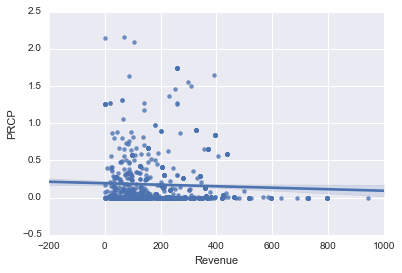

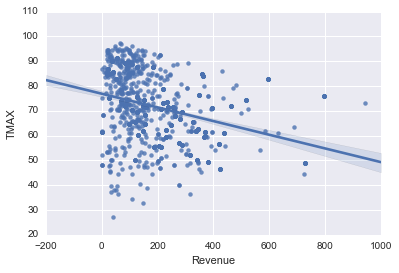

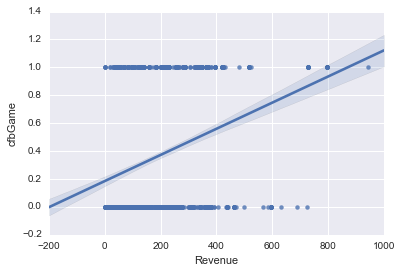

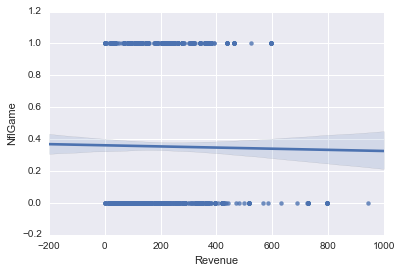

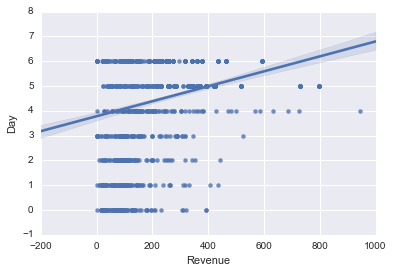

In [97]:
#EDA
plt.figure(1)
plt.subplot(1, 1, 1)
sns.regplot(Final['Revenue'],Final['PRCP'])

plt.figure(2)
plt.subplot(1, 1, 1)
sns.regplot(Final['Revenue'],Final['TMAX'])

plt.figure(3)
plt.subplot(1, 1, 1)
sns.regplot(Final['Revenue'],Final['cfbGame'])

plt.figure(4)
plt.subplot(1, 1, 1)
sns.regplot(Final['Revenue'],Final['NflGame'])

plt.figure(5)
plt.subplot(1, 1, 1)
sns.regplot(Final['Revenue'],Final['Day'])


### EDA Summary

Our EDA confirms much of what we already knew. There are correlations with many of the metrics that we are using. We will use online conversions as a metric as that is our ultimate goal as a digital marketing firm and revenue takes into account revenue from other avenues than online sales. We can also look at other metrics such as click through rate (CTR) or return on ad spend (ROAS) to see how these events influence internet traffic.

In [98]:
#Using category codes for columns with many categorical variables (winners/losers of games, tv network, etc)
for i in Final.columns:
    if Final[i].dtype == object:
        Final[i] = Final[i].astype('category')
        Final[i] = Final[i].cat.codes
    

In [99]:
Final.dropna(inplace=True)
Final.shape

(1386, 17)

In [100]:
#creating target and predictors
y=Final['Conversions']
X=Final.drop(Final.ix[:,10:], axis=1)

In [101]:
X.head()

,PRCP,TMAX,TMIN,CfbWinner,CfbLoser,CfbTV,cfbGame,Winner/tie,Loser/tie,NflGame
2014-08-01,0.590833,81.666667,66.666667,-1,-1,-1,0.0,-1,-1,0.0
2014-08-02,0.010952,84.333333,66.666667,-1,-1,-1,0.0,-1,-1,0.0
2014-08-03,0.000476,88.333333,66.666667,-1,-1,-1,0.0,-1,-1,0.0
2014-08-04,0.000000,89.666667,68.333333,-1,-1,-1,0.0,-1,-1,0.0
2014-08-05,0.000000,89.333333,67.333333,-1,-1,-1,0.0,-1,-1,0.0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

In [103]:
#fitting a decision tree model using cross validation
cv = KFold(len(y_train), shuffle=False) 
print cv
dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt, X_train, y_train, cv=cv,n_jobs=1)
print "Regular Decision Tree scores are:", dtScore
print "Regular Decision Tree average score is:", dtScore.mean()

sklearn.cross_validation.KFold(n=970, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.35845017  0.69292159  0.60097344]
Regular Decision Tree average score is: 0.550781731465


In [104]:
#fitting a random forest model using cross validation and comparing it to previous model

rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf, X_train,y_train, cv=cv, n_jobs=1)
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Random Forest scores are: [ 0.68383661  0.79189363  0.81283321]
Regular Decision Tree scores are: [ 0.35845017  0.69292159  0.60097344]
Random Forest average score is: 0.76285448479
Regular Decision Tree average score is: 0.550781731465


In [105]:
#fitting a adaboost model using cross validation and comparing it to previous model

ab = AdaBoostRegressor(random_state=5)
abScore = cross_val_score(ab, X_train,y_train, cv=cv, n_jobs=1)
print "Adaptive Boost scores are :",abScore
print "Random Forest scores are:", rfScore
print "Regular Decision Tree scores are:", dtScore
print "Average Boost average score is:",abScore.mean()
print "Random Forest average score is:", rfScore.mean()
print "Regular Decision Tree average score is:", dtScore.mean()

Adaptive Boost scores are : [ 0.29939524  0.57880667  0.49460063]
Random Forest scores are: [ 0.68383661  0.79189363  0.81283321]
Regular Decision Tree scores are: [ 0.35845017  0.69292159  0.60097344]
Average Boost average score is: 0.457600845138
Random Forest average score is: 0.76285448479
Regular Decision Tree average score is: 0.550781731465


In [106]:
#plotting cross-validated models
def do_plot(model, m=None):
    for fold, color in zip(cv, ['r','g','b']):#colors are from different folds from Kfold, so 3 diff models
        
        X_train = X.iloc[fold[0]]
        X_test =  X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.scatter(y_test, y_pred, color=color)
        plt.plot([0,60],[0,60])
        plt.text(60,60, "R2:"+str(m), fontsize=20, )
        plt.xlabel('Actual Conversions')
        plt.ylabel('Predicted Conversions')

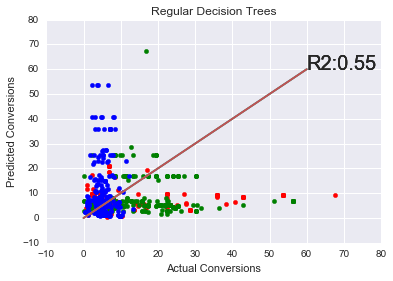

In [107]:
do_plot(dt, dtScore.mean().round(2))
plt.title("Regular Decision Trees")

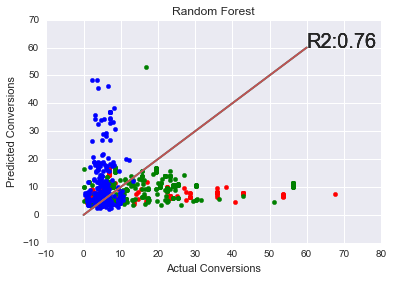

In [108]:
do_plot(rf, rfScore.mean().round(2))
plt.title("Random Forest")

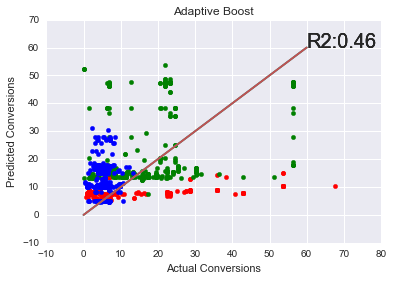

In [109]:
do_plot(ab, abScore.mean().round(2))
plt.title("Adaptive Boost")

### Model Summary

We can see that the random forest model is clearly the best model that has been produced. The model has a much better score than the regular decision tree and Adaboost, but we can see the models don't seem to follow the regression line that well. This also may be a sign that we are over-fitting our model and we can tweak the model in the future to generalize it more. We will also be building an actual decision tree based on the random forest so that we can use it to predict sales, or when to use promotions according to the factors in the model.

Part 2 Score |  19/21
-------|-----
Identify: Articulate Problem Statement/Specific goals & success criteria		|		3
Identify: Outline proposed methods & models		| 3 
Parse: Identify risks & assumptions				| 2 (need more here) 
Parse: Create local PostgreSQL database			| 3
Parse: Query, Sort, & Clean Data				| 3
Parse: Create a Data Dictionary				| 0
Mine: Perform & summarize EDA				| 2 (correlation heatmap, etc.)
Bonus! Refine: Explain how you intend to tune & evaluate your results | 3

Part 3 Score |  14/15
-------|-----
Mine: Correlate data & run statistical analysis		| 2
Refine: Plot data w visual analysis				| 3
Model: Run model on data (train subset as needed)			| 3
Present: Summarize approach & initial results				| 3
Present: Describe successes, setbacks, & lessons learned  | 3
Bonus: Use 2 or more dataviz tools | 0